In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
pwd

'/aiffel/aiffel/aiffel_quest/quest_240304'

In [3]:
# 데이터 경로
DATA_PATH = os.getenv('HOME') + '/aiffel/aiffel_quest/quest_240304/data/'

# 데이터 불러오기
eth_data = pd.read_csv(DATA_PATH + 'sub_upbit_eth_min_tick.csv', index_col=0, parse_dates=True)

eth_data.head(), eth_data.tail()

(                       open    high     low   close     volume
 time                                                          
 2017-09-25 03:00:00  324500  325500  322000  324000  52.477251
 2017-09-25 03:01:00  324000  324000  322500  324000  39.061889
 2017-09-25 03:02:00  322500  324500  322500  324500  12.794000
 2017-09-25 03:05:00  324000  324000  323000  324000  33.365246
 2017-09-25 03:06:00  324000  325000  322500  324000  46.224544,
                        open    high     low   close      volume
 time                                                           
 2019-11-03 10:29:00  212650  212800  212600  212800   30.996276
 2019-11-03 10:30:00  212800  212800  212600  212600    3.224132
 2019-11-03 10:31:00  212600  212600  212400  212400  135.351681
 2019-11-03 10:32:00  212400  212500  212150  212500  329.331920
 2019-11-03 10:33:00  212400  212500  212200  212350  141.525940)

<AxesSubplot:xlabel='time'>

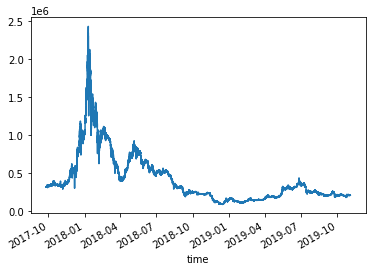

In [5]:
# 데이터로 시각화

eth_data.loc['2017-09-25': '2019-11-03','close'].plot()

## Data Labeling

#### Price Change Direction 적용

In [8]:
# window 지정
window = 10

# momentum_signal 지정
momentum_signal = np.sign(np.sign(eth_data['close'] - eth_data['close'].shift(window)) +1 )

# s_momentum_signal 지정
s_momentum_signal = pd.Series(momentum_signal, index=eth_data.index)

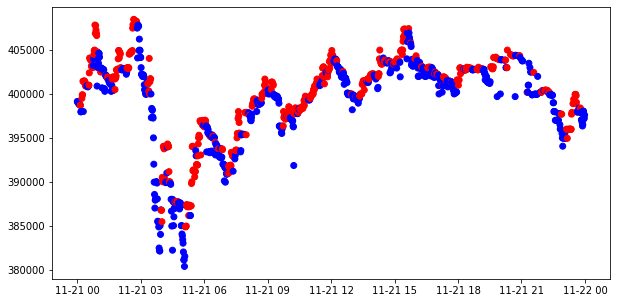

In [10]:
sub_data = eth_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 데이터 비교 위해 색상 바꾸기
c_sig['color'] = np.where(c_sig==1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

#### Using Moving Average 적용

In [13]:
momentum_signal = np.sign(np.sign(eth_data['close'] - eth_data['close'].rolling(window).mean()) +1)

s_momentum_signal = pd.Series(momentum_signal, index=eth_data.index)

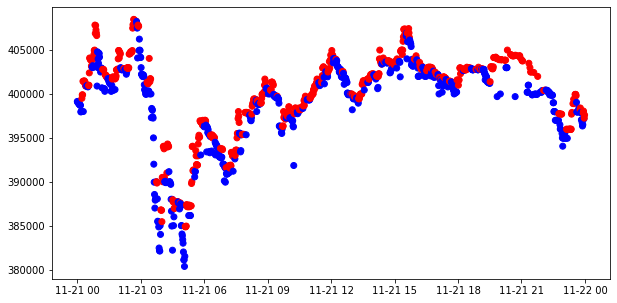

In [14]:
sub_data = eth_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 데이터 비교 위해 색상 바꾸기
c_sig['color'] = np.where(c_sig==1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

#### Local Min-Max 적용

In [15]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [20]:
mins, maxes = get_local_min_max(sub_data, wait=3)

In [21]:
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

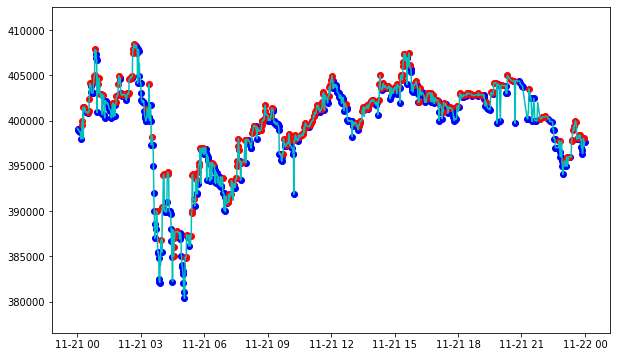

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.plot(sub_data, 'c')

ax.scatter(mins.min_time, mins.local_min, c='blue')

ax.scatter(maxes.max_time, maxes.local_max, c='red')

ax.set_ylim([sub_data.min() * 0.99, sub_data.max() * 1.01])
# 0.99, 1.01은 데이터의 최솟값과 최댓값을 기준으로 약간의 여유 공간을 확보하기 위함

In [25]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
#     t-value from a linear trend
    x = np.ones((close.shape[0],2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [26]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [28]:
# 시간을 위해 데이터 크기를 줄임

molecule = eth_data['2017-11-01':'2017-11-15'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = eth_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 13404/13404 [05:49<00:00, 38.37it/s]


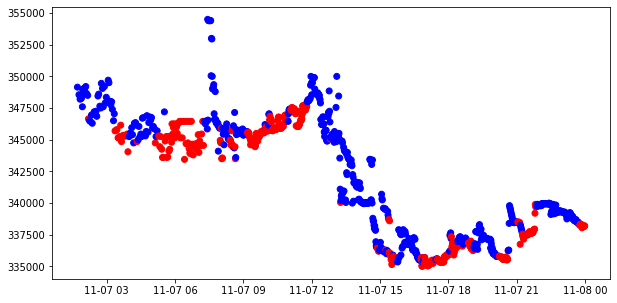

In [30]:
# 시각화
sub_data = eth_data.loc['2017-11-07', 'close']
c_sig = label['bin'].loc['2017-11-07']
c_sig['color'] = np.where(c_sig==1, 'red','blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

## Feature Engineering

In [31]:
!pip install ta==0.9.0
!pip install shap

In [32]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/aiffel_quest/quest_240304/data')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [35]:
# 데이터 경로 설정
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

#시간 단축을 위해 조금만 사용

df_sub_modify_data = df_sub_modify_data.iloc[:1000]

#### Technical Index 적용

In [36]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [37]:
# 수익률/ 변동성 직표 적용

windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)
    
    
for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std{i}'] = df_.volume.rolling(i).std()

In [38]:
df_tmp_data = df_.join(df_label_data).dropna()

# 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1]
y = df_tmp_data.iloc[:, -1]

# StandardScaler 적용
sc = StandardScaler()

X_sc = sc.fit_transform(X)

X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [39]:
# RandomForest
rfc = RandomForestClassifier(class_weight='balanced')

X_rfc = rfc.fit(X_sc, y)

#### Feature Selection methods 적용

In [40]:
# MDI, Mean Decrease Impurity 

feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.049964,0.002348
volume_fi,0.043032,0.002220
volume_mfi,0.048246,0.002629
volume_sma_em,0.036038,0.002007
volume_vpt,0.027275,0.001558
volatility_atr,0.076794,0.003560
volatility_ui,0.046898,0.002181
trend_macd_diff,0.080380,0.003814
trend_adx,0.054868,0.002072
trend_trix,0.068863,0.003198


In [42]:
# MDA, Mean Decrease Accuracy
# svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
# GradientBoost 로 변경
gb_clf = GradientBoostingClassifier() 
cv = KFold(n_splits=10)
feat_imp_mda = imp.mean_decrease_accuracy(gb_clf, X_sc, y, cv_gen=cv)

In [43]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

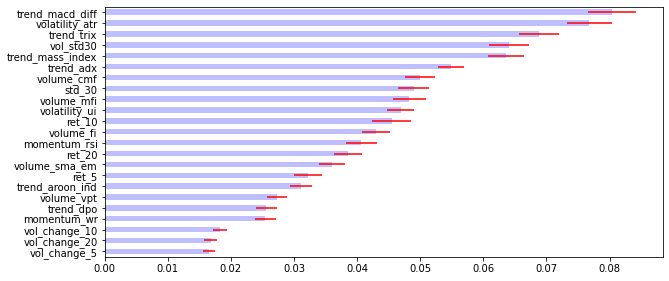

In [44]:
# feat_imp 확인
plot_feature_importance(feat_imp)

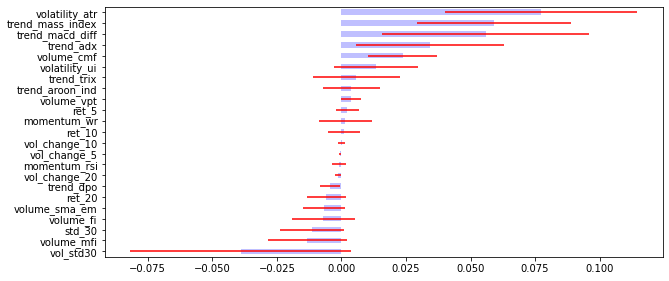

In [45]:
# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)


In [46]:
# RFE CV, Recursive Feature Elimination
gb_clf = GradientBoostingClassifier() 
rfe_cv = RFECV(gb_clf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc,y)# fit 사용

In [47]:
# SFS, Sequential Feature Selection

sfs_forward = SequentialFeatureSelector(gb_clf, n_features_to_select=2, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc,y)

In [50]:
sfs_fitted

SequentialFeatureSelector(estimator=GradientBoostingClassifier(),
                          n_features_to_select=2)

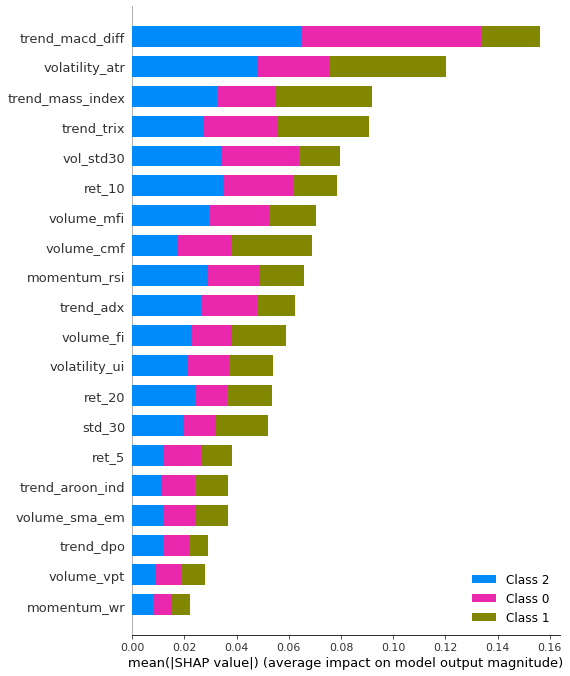

In [49]:
# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

shap.summary_plot(shap_value, X_sc)

## Model Training

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from libs.mlutil.pkfold import PKFold

In [53]:
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')


# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

In [59]:
# 데이터를 1000개로 줄어서 n_cv를 4로 한것 같다. 적은 데이터에 cv값을 크게 하면 훈련에 사용할 데이터가 줄어들기 때문이다.
# 너무 크면 시간과 리소스가 증가하기 때문에 잘 선택해야한다.
n_cv = 6

t1 = pd.Series(train_y.index.values, index=train_y.index)
cv = PKFold(n_cv, t1, 0)

In [60]:
bc_params = {'n_estimators': [10, 15, 20],
             'max_features': [0.3, 0.5],
             'base_estimator__max_depth': [10, 15, 20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [5, 7, 9],
             'bootstrap_features': [False, True]
            }

In [61]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [62]:
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)

Fitting 6 folds for each of 216 candidates, totalling 1296 fits


GridSearchCV(cv=PKFold(n_splits=6, pct_embargo=0,
    samples_info_sets=time
2018-01-01 00:43:00   2018-01-01 00:43:00
2018-01-01 00:44:00   2018-01-01 00:44:00
2018-01-01 00:45:00   2018-01-01 00:45:00
2018-01-01 00:46:00   2018-01-01 00:46:00
2018-01-01 00:47:00   2018-01-01 00:47:00
                              ...
2018-01-01 17:18:00   201...   2018-01-01 17:21:00
2018-01-01 17:22:00   2018-01-01 17:22:00
Length: 1000, dtype: datetime64[ns]),
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced')),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [10, 15, 20],
                         'base_estimator__max_features': [None, 'auto'],
                         'base_estimator__min_samples_leaf': [5, 7, 9],
                         'bootstrap_features': [False, True],
                         'max_features': [0.3, 0.5],
                         'n_estimators': [10, 15, 20]},
             verbose=1)

In [73]:
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        max_features=None,
                                                        min_samples_leaf=9),
                  bootstrap_features=True, max_features=0.5)

In [64]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [65]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y) 
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y) 

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[110657  10655]
 [ 49738  10719]]
정확도:0.667748626003334, 정밀도:0.501497146065313, 재현율:0.17729956828820484


auc:0.5447340956714039


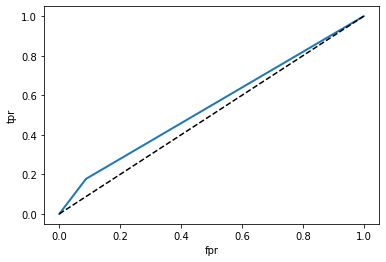

In [68]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)

auc = roc_auc_score(test_y, pred_y)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

In [69]:
train_x = train_x[:4000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:4000]

In [70]:
n_cv = 6

t1 = pd.Series(train_y.index.values, index=train_y.index)
cv = PKFold(n_cv, t1, 0)

In [74]:
bag_rfc = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        max_features=None,
                                                        min_samples_leaf=9),
                  bootstrap_features=True, max_features=0.5)
bag_rfc.fit(train_x, train_y)

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        max_features=None,
                                                        min_samples_leaf=9),
                  bootstrap_features=True, max_features=0.5)

In [75]:
pred_y = bag_rfc.predict(test_x)
prob_y = bag_rfc.predict_proba(test_x)

In [76]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y) 
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y) 

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[109122  12190]
 [ 50243  10214]]
정확도:0.6565255901721415, 정밀도:0.4559007320121407, 재현율:0.16894652397571827


auc:0.534230911684509


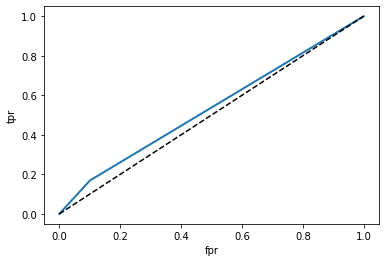

In [77]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)

auc = roc_auc_score(test_y, pred_y)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')